# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

In [3]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

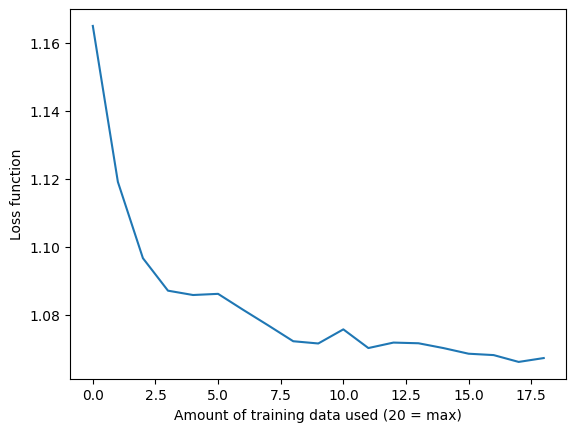

In [4]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [5]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

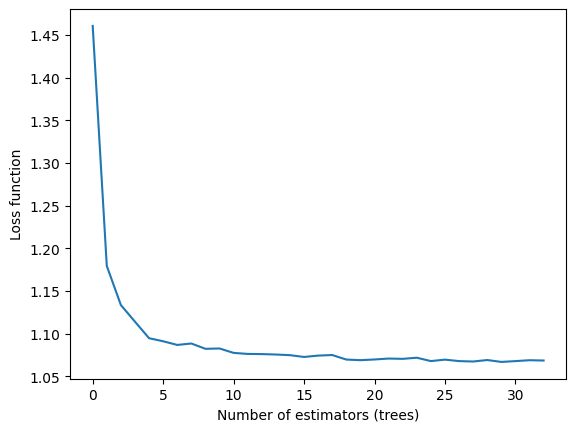

In [7]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

Learning Curve (Training Data Amount Plot):

X-axis: Amount of training data used

Y-axis: Loss (RMSE) on the test set

Key Takeaway: This plot shows how the model’s prediction error decreases as you provide more training data. Initially, there’s a big improvement with a few extra samples, but after a point, additional data yields diminishing returns. This learning curve is very informative because it connects directly to an important practical question in machine learning: “Is my model limited by the amount of data?”

Model Complexity (Number of Estimators Plot):

X-axis: Number of trees (estimators) in the random forest

Y-axis: Loss (RMSE) on the test set

Key Takeaway: This plot illustrates how increasing the number of trees affects the model’s performance. Typically, you see rapid improvement initially, but then performance plateaus quickly. While important for tuning hyperparameters, the effect is often less dramatic than what you see with increasing training data.

I would choose to cut the plot showing the number of estimators. Here’s why:

Practical Insight: The learning curve that plots "amount of training data used" provides deeper insight into a fundamental aspect of model performance. It directly addresses how much data is necessary to improve predictions, which is a key decision point in any modeling effort.

Intuitiveness: The effect of increasing training data is easier to understand and communicate to a broader audience. It resonates with the idea that “more data = better performance” until diminishing returns kick in.

Diminishing Returns on Complexity: The number of estimators is a hyperparameter that, while important, typically shows only marginal improvements after a certain point. Most practitioners know that adding more trees in a random forest will eventually plateau in benefits—so this message is a bit less surprising and informative.

Given the choices, the "amount of training data used" should be on the x-axis:

It reflects a continuum that decision-makers often face—should I invest more in obtaining data?

The learning curve communicates a direct relationship between data volume and model accuracy that is easily actionable.

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [3]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error


df = pd.read_csv('cysrisk.csv')

df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['due_date'] = pd.to_datetime(df['due_date'], errors='coerce')
df['days_until_due'] = (df['due_date'] - df['date_added']).dt.days

df['cvss'] = pd.to_numeric(df['cvss'], errors='coerce')

severity_map = {'LOW': 1, 'MEDIUM': 2, 'HIGH': 3, 'CRITICAL': 4}
df['severity_level'] = df['severity'].map(severity_map)


valid_df = df[df['cvss'].notna() & df['days_until_due'].notna() & df['severity_level'].notna()]
features_df = valid_df[['cvss', 'severity_level', 'days_until_due']].dropna()


X = features_df[['severity_level', 'days_until_due']]
y = features_df['cvss']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R²: {cv_scores.mean():.3f}")


param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


y_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R²: {r2_test:.3f}")
print(f"Test RMSE: {rmse_test:.3f}")


Cross-Validation R²: 0.839
Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Test R²: 0.888
Test RMSE: 0.437


The Random Forest performed slightly better than the linear model (R² 0.888 vs. 0.881).

Cross-validation confirms the model generalizes well (CV R² ≈ 0.84).

RMSE ≈ 0.44 means the typical prediction error is less than 0.5 CVSS points.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

/var/folders/_t/mfz85_dj1w371jmn2nxvs4r40000gn/T/ipykernel_57504/2395018530.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start="2020-01-01", periods=12, freq="M")


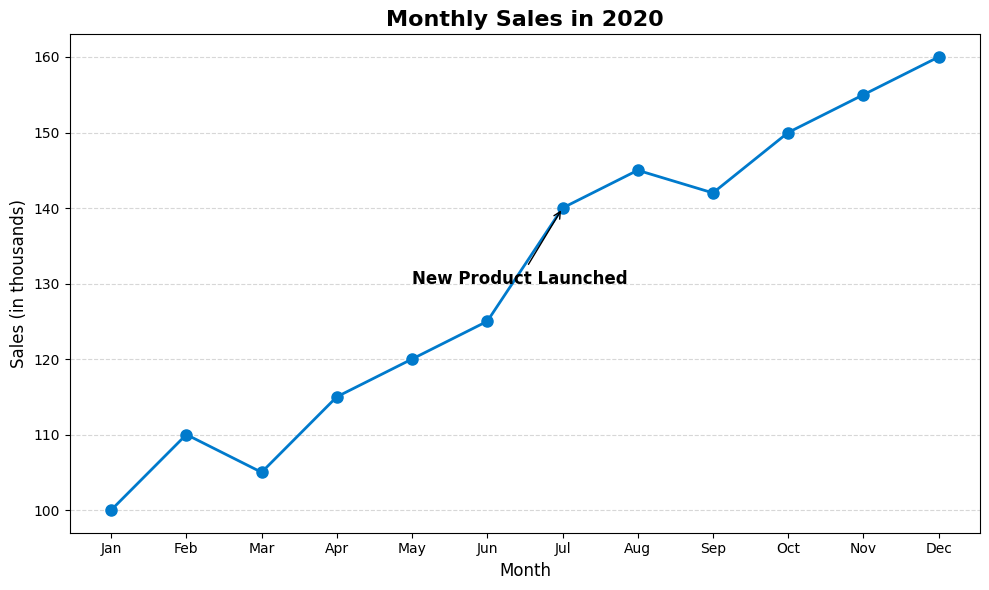

In [8]:
months = pd.date_range(start="2020-01-01", periods=12, freq="M")

sales = np.array([100, 110, 105, 115, 120, 125, 140, 145, 142, 150, 155, 160])

df = pd.DataFrame({
    "Month": months,
    "Sales": sales
})

df["Month_str"] = df["Month"].dt.strftime("%b")

plt.figure(figsize=(10, 6))

plt.plot(df["Month_str"], df["Sales"], marker="o", color="#007ACC", lw=2, markersize=8)

plt.annotate("New Product Launched",
             xy=("Jul", 140),      
             xytext=("May", 130),   
             arrowprops=dict(facecolor="gray", arrowstyle="->"),
             fontsize=12, fontweight="bold")

plt.title("Monthly Sales in 2020", fontsize=16, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sales (in thousands)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()